In [1]:
import rospy
import rosbag
from sensor_msgs.msg import PointCloud2
from sensor_msgs import point_cloud2
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from nlos_sensing import line_by_2p, intersection_of_2line

Failed to load Python extension for LZ4 support. LZ4 compression will not be available.


In [2]:
file_path = "/home/dingrong/Code/ackermann_car_nav/data/20230530/floor31_h1_180_L_120_angle_0_param1_2023-05-30-16-03-36"
bag = rosbag.Bag(f"{file_path}.bag")
bag_data = bag.read_messages(topics=['/laser_point_cloud', '/laser_point_cloud2', '/mmwave_radar_point_cloud'])

laser_list, laser_list2, mmwave_list = [], [], []
for topic, msg, t in bag_data:
    if topic == '/laser_point_cloud':
        points = point_cloud2.read_points_list(
            msg, field_names=['x', 'y']
        )
        x_pos = [p.x for p in points]
        y_pos = [p.y for p in points]
        point_cloud = np.array([x_pos, y_pos]).T
        laser_list.append((t.to_sec(), point_cloud))
    if topic == '/laser_point_cloud2':
        points = point_cloud2.read_points_list(
            msg, field_names=['x', 'y']
        )
        x_pos = [p.x for p in points]
        y_pos = [p.y for p in points]
        point_cloud = np.array([x_pos, y_pos]).T
        laser_list2.append((t.to_sec(), point_cloud))
    if topic == '/mmwave_radar_point_cloud':
        points = point_cloud2.read_points_list(
            msg, field_names=['x', 'y', 'z', 'vel', 'snr']
        )
        x_pos = [p.x for p in points]
        y_pos = [p.y for p in points]
        z_pos = [p.z for p in points]
        vel = [p.vel for p in points]
        snr = [p.snr for p in points]
        point_cloud = np.array([x_pos, y_pos, z_pos, vel, snr]).T
        mmwave_list.append((t.to_sec(), point_cloud))

In [3]:
def align_sensors(laser_list, mmwave_list):
    laser_len, mmwave_len = len(laser_list), len(mmwave_list)
    if laser_len < mmwave_len:
        raise Exception("Wrong")
    min_idx, min_v = 0, np.inf
    for i in range(laser_len-mmwave_len+1):
        diff = np.abs(laser_list[i][0] - mmwave_list[0][0])
        if diff < min_v:
            min_v = diff
            min_idx = i
    return laser_list[min_idx:]

In [4]:
laser_list = align_sensors(laser_list, mmwave_list)
laser_list2 = align_sensors(laser_list2, mmwave_list)

In [5]:
n_frame = 100
laser_n_frame = np.concatenate([p for t, p in laser_list2[:n_frame]], axis=0)

In [6]:
# local_sensing_range = [-2, -0.5, -2.5, -1]  # 切割小车
local_sensing_range = [-2, 0, -2.9, -2]
# local_sensing_range = [-8, 2, 0, 1.5]  # 切割人
flag_x = np.logical_and(laser_n_frame[:, 0]>=local_sensing_range[0], laser_n_frame[:, 0]<=local_sensing_range[1])
flag_y = np.logical_and(laser_n_frame[:, 1]>=local_sensing_range[2], laser_n_frame[:, 1]<=local_sensing_range[3])
flag = np.logical_and(flag_x, flag_y)
laser_part = laser_n_frame[flag]
laser_part.shape

(481, 2)

In [7]:
# 先聚类，提取右边2堆点云，计算均值
filter = DBSCAN(eps=0.02, min_samples=3)
db = filter.fit(laser_part)
labels = db.labels_
n_cluster = len(set(labels[labels>-1]))
n_cluster

9

IndexError: list index out of range

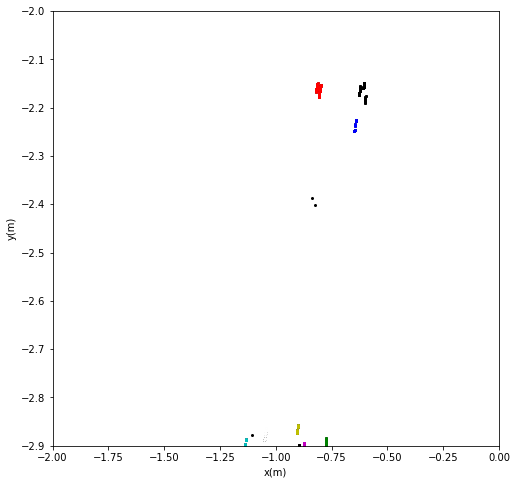

In [8]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_xlabel('x(m)')
ax.set_ylabel('y(m)')
ax.set_xlim([local_sensing_range[0], local_sensing_range[1]])
ax.set_ylim([local_sensing_range[2], local_sensing_range[3]])
color_panel = ['ro', 'go', 'bo', 'co', 'wo', 'yo', 'mo', 'ko']
ax.plot(laser_part[:, 0], laser_part[:, 1], color_panel[-1], ms=2)

cluster_list = []
for i in range(n_cluster):
    cluster = laser_part[labels==i]
    cluster_list.append(cluster)
    ax.plot(cluster[:, 0], cluster[:, 1], color_panel[i], ms=2)
if n_cluster >= 4:
    # front_right = np.mean(cluster_list[0], axis=0)
    front_right = np.mean(cluster_list[1], axis=0)
    # back_right = np.mean(cluster_list[2], axis=0)
    back_right = np.mean(cluster_list[3], axis=0)
elif n_cluster == 3:
    front_right = np.mean(cluster_list[0], axis=0)
    back_right = np.mean(cluster_list[1], axis=0)
else:
    front_right = np.mean(cluster_list[0], axis=0)
    back_right = np.mean(cluster_list[1], axis=0)
ax.plot(*front_right, 'sy', ms=6)
ax.plot(*back_right, 'sy', ms=6)

In [ ]:
# np.linalg.norm(back_right-back_left), 
np.linalg.norm(front_right-back_right)

0.31131996289791625

In [ ]:
coef = line_by_2p(front_right, back_right)
theta = np.arctan(coef[0]) + np.pi if coef[0] < 0 else np.arctan(coef[0])
theta * 180 / np.pi

114.56971073691246

In [ ]:
# 我想知道，小车中心点在标定激光雷达坐标系下的位置
k = (front_right[1] - back_right[1]) / (front_right[0] - back_right[0])
l = 0.11
w = 0.105
deltax = l * -np.cos(theta)
deltay = l * np.sin(theta)
x1 = front_right[0] + deltax
y1 = front_right[1] - deltay
coef1 = [-1/k, 1/k*x1+y1]

deltax = w * np.sin(theta)
deltay = w * -np.cos(theta)
x2 = back_right[0] - deltax
y2 = back_right[1] - deltay
coef2 = [k, -k*x2+y2]

inter = intersection_of_2line(coef1, coef2)
inter

array([-1.27231678, -2.54684086])

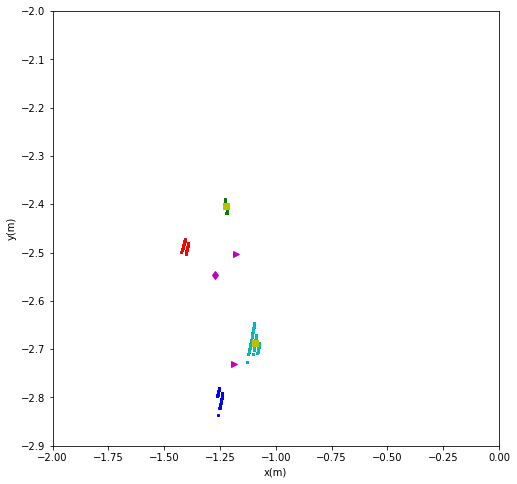

In [ ]:
ax.plot(x1, y1, '>m', ms=6)
ax.plot(x2, y2, '>m', ms=6)
ax.plot(*inter, 'dm', ms=6)
fig

In [ ]:
transform = (inter, theta)
all_point_cloud = []
for i in range(len(mmwave_list)):
    tmp = (laser_list[i][0], laser_list[i][1], laser_list2[i][1], mmwave_list[i][1], transform)
    all_point_cloud.append(tmp)
with open(f"{file_path}.pkl", 'wb') as f:
    pickle.dump(all_point_cloud, f)